In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [4]:
from torchsample.modules import ModuleTrainer
from torchsample.callbacks import EarlyStopping, ReduceLROnPlateau
from torchsample.regularizers import L1Regularizer, L2Regularizer
from torchsample.constraints import UnitNorm
from torchsample.initializers import XavierUniform
from torchsample.metrics import CategoricalAccuracy
from torchsample import TensorDataset
from torch.autograd import Variable

import random

In [5]:
LABELS = [
    'index_1', 'index_2', 'index_3',
    'middle_1', 'middle_2', 'middle_3',
    'ring_1', 'ring_2', 'ring_3',
    'little_1', 'little_2', 'little_3',
    'palm', 'background'
]

train_img_names  = []
train_img_labels = [] 

val_img_names  = []
val_img_labels = [] 

idx = 0
save_path = "./data/"

for file in glob.glob(save_path + '*'):
    os.remove(file)

for label in LABELS:
    dir_path = os.path.join('./' , label)
    all_img = []
    for img_src in sorted(glob.glob(dir_path  + '/*' )) :
        img = cv2.imread(img_src)
        img = cv2.resize(img, (300,300))
        img_name = save_path + str(idx) + '.jpg'
        idx += 1
        cv2.imwrite(img_name, img)
        if( 'val' not in img_src ):
            train_img_names.append(img_name)
            train_img_labels.append(label)
        else:
            val_img_names.append(img_name)
            val_img_labels.append(label)

In [6]:
d_train = {'img_names': train_img_names, 'img_labels': train_img_labels}
df_train = pd.DataFrame(data=d_train)
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.to_csv("train_data_info.csv", sep='\t', index=False)

d_val = {'img_names': val_img_names, 'img_labels': val_img_labels}
df_val = pd.DataFrame(data=d_val)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_val.to_csv("val_data_info.csv", sep='\t', index=False)

print('# train instance:',len(df_train))
print('# val instance:',len(df_val))
print('[train_data_info.csv overview]')
df_train.head()

# train instance: 24875
# val instance: 2786
[train_data_info.csv overview]


,img_labels,img_names
0,middle_1,./data/7400.jpg
1,index_1,./data/226.jpg
2,index_2,./data/2073.jpg
3,ring_1,./data/12837.jpg
4,palm,./data/25016.jpg


In [7]:
class JointDataset(torch.utils.data.Dataset):

    def __init__(self, dir_path, labels, csv_file):
        self.labels = labels
        self.data_info = pd.read_csv(csv_file, sep='\t')
        self.num_inputs = 1
        self.num_targets = 1

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_info.img_names[idx])
        image = cv2.imread(img_name).astype('float32') / 255.0
        x = np.rollaxis(image, 2, 0)
        label = self.data_info.img_labels[idx]
        y = self.labels.index(label)
        # turn your label to a number, and then turn them to a tensor.
        return (x, y)

image shape : (3, 300, 300) 	lable :  1
index_2


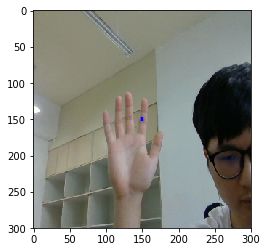

In [8]:
train_Dataset = JointDataset(dir_path='./data',labels=LABELS, csv_file='train_data_info.csv')
val_Dataset = JointDataset(dir_path='./data',labels=LABELS, csv_file='val_data_info.csv')
i = random.randint(0,1000)
x, y = train_Dataset.__getitem__(i)
print('image shape :', x.shape, '\tlable : ', y)
print(LABELS[y])
img = cv2.cvtColor(np.rollaxis(x,0,3) , cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [9]:
train_loader = DataLoader(train_Dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_Dataset, batch_size=32, shuffle=True)
for step, (x, y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
    batch_x = Variable(x)  
    batch_y = Variable(y)
    print(batch_x.size())
    print(batch_y.size())
    break

torch.Size([32, 3, 300, 300])
torch.Size([32])


In [10]:
class MyCNN(nn.Module):
    def __init__(self, num_class):
        super(MyCNN, self).__init__()
        # conv_1
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), 
            # input shape (3, 100, 100), output shape (16, 50, 50)
        )
        # conv_2
        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), 
            # input shape (16, 50, 50), output shape (32, 25, 25)
        ) 
        # output
        self.fc_1 = nn.Linear(in_features=32 * 75 * 75, out_features=128) 
        self.fc_2 = nn.Linear(in_features=128, out_features=num_class)
        self.num_class = num_class
    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = x.view(x.size(0), -1)  # flatten the output of conv2 to (batch_size, 32 * 25 * 25)
        x = F.relu(self.fc_1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc_2(x)
        return F.log_softmax(x)        

In [11]:
model = MyCNN(num_class=len(LABELS))
print(model)
trainer = ModuleTrainer(model)

MyCNN(
  (conv_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_1): Linear(in_features=180000, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=13, bias=True)
)


In [12]:
""" Trainer Parameter """

sgd_momentum  = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
adam = torch.optim.Adam(model.parameters(), lr=0.01)

# patience: 没有進步的訓練輪數，在這之後訓練就會停止。
# ReduceLROnPlateau: 當標準評估已經停止時，降低學習速率。  (Plateau :高原 )
callbacks = [EarlyStopping(patience=10), 
             ReduceLROnPlateau(factor=0.5, patience=5)]

# Regularizer: 正則化 (module_filter=用在哪一層)
regularizers = [L1Regularizer(scale=1e-3, module_filter='conv*'),
                L2Regularizer(scale=1e-5, module_filter='fc*')]

# Constraint 在優化期間對網絡參數設置約束
constraints = [UnitNorm(frequency=3, unit='batch', module_filter='fc*')]

initializers = [XavierUniform(bias=False, module_filter='fc*')]
# metrics 用於評估當前訓練模型的性能
# 評價函數和損失函數相似，只不過評價函數的結果不會用於訓練過程中
# metrics = [CategoricalAccuracy(top_k=3)]
metrics = [CategoricalAccuracy(top_k=1)]
# nll_loss(Negative_Log_Likelihood Loss) 前面接上一个 nn.LogSoftMax 層就等價於 CrossEntropyLoss 了 
trainer.compile(loss='nll_loss',
                optimizer='adam' ,
                regularizers=regularizers,
                constraints=constraints,
                initializers=initializers,
                metrics=metrics, 
                callbacks=callbacks)

In [20]:
trainer.fit_loader(loader=train_loader, val_loader=val_loader, num_epoch=3, verbose=1)

Epoch 1/3:   0%|                      | 1/367 [00:05<35:07,  5.76s/ batches]


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [14]:
def preprocess_img(img_src):
    image = cv2.imread(img_src)
    image = cv2.resize(image, (300,300))
    image = image.astype('float32') / 255.0
    x = np.rollaxis(image, 2, 0)
    return torch.from_numpy( np.array([x]) )

index : 225  predict : index_3 ( [0.0127 0.0008 0.9516 0.     0.     0.0026 0.     0.0285 0.     0.0036
 0.     0.0002 0.    ] 2 )


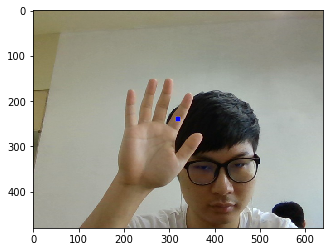

index : 578  predict : palm ( [0.0095 0.     0.0029 0.     0.     0.0005 0.     0.0004 0.     0.0053
 0.     0.0006 0.9806] 12 )


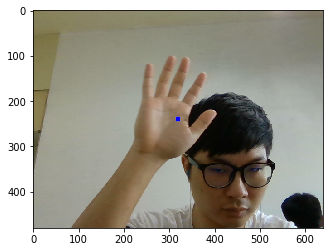

index : 415  predict : index_3 ( [0.     0.     0.8096 0.0001 0.189  0.     0.     0.     0.0001 0.
 0.     0.     0.0012] 2 )


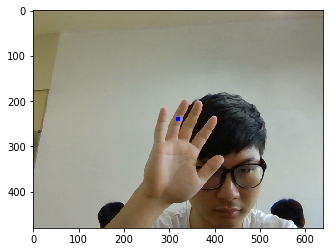

index : 384  predict : middle_1 ( [0.     0.004  0.358  0.4919 0.0393 0.0002 0.0001 0.0005 0.0044 0.0121
 0.0539 0.0025 0.0331] 3 )


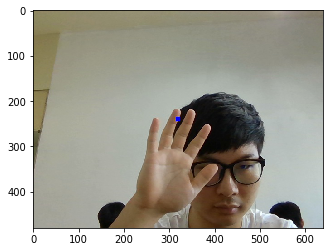

index : 175  predict : index_2 ( [0.0326 0.6028 0.2497 0.     0.     0.0005 0.     0.     0.     0.0309
 0.0834 0.     0.    ] 1 )


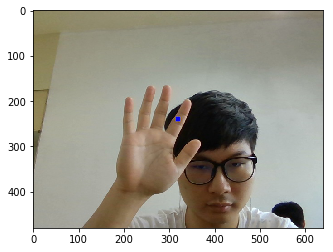

In [24]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)

def show_predict(idx):
    img_src = './test/' + str(idx) +  '.jpg's
    x = preprocess_img(img_src)
    out_pred = model(x)
    prob, y_pred = torch.max(out_pred, 1)
    label_pred = LABELS[y_pred.item()]
    print('index :', idx, ' predict :', label_pred, '(', torch.exp(out_pred).data.numpy()[0], y_pred.item(),')' )
    
    img = cv2.imread(img_src)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()


for i in range(5):
    idx = random.randint(100, 600)
#     idx = 1
    show_predict(idx)